<h1><b>Self Driving Car using CNN(EfficientNetB1) + RNN(LSTM)</b></h1>

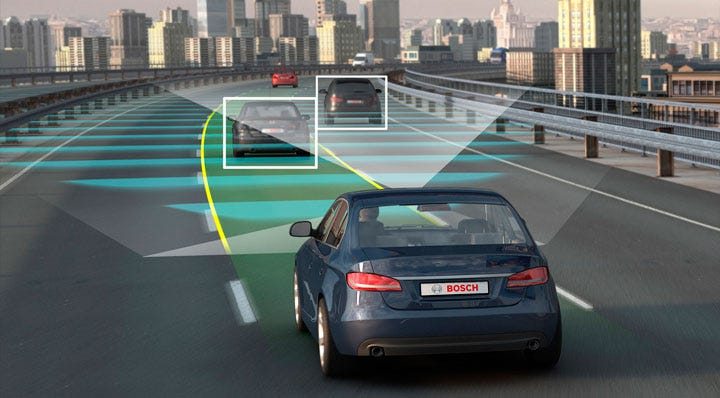

<h2><b>1. Introduction</b></h2>

*   Used convolutional neural networks (CNNs) to map the raw pixels from a front-facing camera to the steering commands for a self-driving car. This powerful end-to-end approach means that with minimum training data from humans, the system learns to steer, with or without lane markings, on both local roads and highways. The system can also operate in areas with unclear visual guidance such as parking lots or unpaved roads.

*   The system is trained to automatically learn the internal representations of necessary processing steps, such as detecting useful road features, with only the human steering angle as the training signal. We do not need to explicitly trained it to detect, for example, the outline of roads.

*   End-to-end learning leads to better performance and smaller systems. Better performance results because the internal components self-optimize to maximize overall system performance, instead of optimizing human-selected intermediate criteria, e. g., lane detection. Such criteria understandably are selected for ease of human interpretation which doesn’t automatically guarantee maximum system performance. Smaller networks are possible because the system learns to solve the problem with the minimal number of processing steps.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing all required Libraries and Modules

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import re
import warnings
warnings.filterwarnings("ignore")

import requests
from PIL import Image
from io import BytesIO

from collections import Counter
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from __future__ import division
import os
import random
import time

from scipy import pi
from itertools import islice

import gc
import concurrent.futures
from functools import partial

from keras.models import Model
#from efficientnet.keras import EfficientNetB1
#from keras.applications.efficientnet import preprocess_input
from keras.layers import GlobalAveragePooling2D, AveragePooling2D

from tensorflow.keras.applications import EfficientNetB1
import tensorflow as tf
from tensorflow.keras.layers import Lambda
from tensorflow.keras import layers
import keras

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import Convolution2D,Dense,MaxPooling2D,Dropout,Flatten, Input, LSTM, Bidirectional, Reshape, TimeDistributed

<h2><b>2. About the Dataset</b></h2>

<h4><i><p>For a self-driving car project, your dataset seems to contain images along with their corresponding file paths and angles in degrees. This dataset is likely used for training a model to predict steering angles based on the images captured by the car's sensors.</p></i></h4>

1.   <h5><b>ImageId: </b></h5> This column likely contains unique identifiers or names for each image in your dataset. These could be numerical IDs, alphanumeric codes, or any other unique identifier assigned to each image.
2.   <h5><b>ImagePath: </b></h5> This column contains the file paths to the images in your dataset. These paths specify the location of each image file on your filesystem. They could be absolute paths or relative paths depending on how your dataset is structured.

3.   <h5><b>Angles: </b></h5> This column contains the steering angles corresponding to each image in your dataset, represented in degrees. These angles indicate the direction in which the vehicle should steer at the time the image was captured. Positive angles may correspond to turning right, while negative angles may correspond to turning left.



In [ ]:
# read images and steering angles from driving_dataset folder

DATA_FOLDER = '/content/drive/MyDrive/SelfDrivingCar/Datasets/'
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')

image_path = []
angles = []
with open(TRAIN_FILE) as fp:
    for line in fp:
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        image_path.append(full_path)

        # converting angle from degrees to radians
        angles.append(float(angle) * pi / 180 )


angles = np.array(angles)

print("Completed processing data.txt")

Completed processing data.txt


In [ ]:
# Extracting the uploaded zip file of the image dataset

# !!! Use if need it. !!!

# import shutil

# def extract_all(zip_file, extract_dir):
#     shutil.unpack_archive(zip_file, extract_dir, 'zip')

# if __name__ == "__main__":
#     zip_file = '/content/drive/MyDrive/SelfDrivingCar/Datasets/driving_dataset.zip'
#     extract_dir = '/content/drive/MyDrive/SelfDrivingCar/Datasets/Data/'

#     # Create the directory if it doesn't exist
#     if not os.path.exists(extract_dir):
#         os.makedirs(extract_dir)

#     extract_all(zip_file, extract_dir)

In [ ]:
extract_dir = '/content/drive/MyDrive/SelfDrivingCar/Datasets/Data/'

im_dir = extract_dir+'driving_dataset'
file_list = os.listdir(im_dir)
len(file_list)

In [ ]:
# Rename the file
# Example: 0.jpg to 00000.jpg
#          915.jpg to 00915.jpg

# !!! Use if need it !!!

for file in file_list:
    if file.lower().endswith(('.jpg','.png','.jpeg')):
        file_name, ext = os.path.splitext(file)
        new_filename = file_name.zfill(5)
        new_filename_with_ext = os.path.join(im_dir, new_filename + ext)
        # Rename the file
        os.rename(os.path.join(im_dir, file), new_filename_with_ext)
print('Files Renamed Completed.')

Files Renamed Completed.


<h2><b>3. EDA (Exploratory Data Analysis)</b></h2>

In [ ]:
for i in range(1085, 1100):
    print(f"{image_path[i]}------{angles[i]}")

/content/drive/MyDrive/SelfDrivingCar/Datasets/1085.jpg------0.30089476304382234
/content/drive/MyDrive/SelfDrivingCar/Datasets/1086.jpg------0.3202679177409595
/content/drive/MyDrive/SelfDrivingCar/Datasets/1087.jpg------0.33789574318610216
/content/drive/MyDrive/SelfDrivingCar/Datasets/1088.jpg------0.35028758087526196
/content/drive/MyDrive/SelfDrivingCar/Datasets/1089.jpg------0.3590142271352336
/content/drive/MyDrive/SelfDrivingCar/Datasets/1090.jpg------0.36250488563922223
/content/drive/MyDrive/SelfDrivingCar/Datasets/1091.jpg------0.36425021489121656
/content/drive/MyDrive/SelfDrivingCar/Datasets/1092.jpg------0.3679154063204046
/content/drive/MyDrive/SelfDrivingCar/Datasets/1093.jpg------0.3731513940763876
/content/drive/MyDrive/SelfDrivingCar/Datasets/1094.jpg------0.3731513940763876
/content/drive/MyDrive/SelfDrivingCar/Datasets/1095.jpg------0.3731513940763876
/content/drive/MyDrive/SelfDrivingCar/Datasets/1096.jpg------0.374896723328382
/content/drive/MyDrive/SelfDrivingCa

In [ ]:
# Create a DataFrame
df = pd.DataFrame({'image_path': image_path, 'angles': angles})
df.head()

,image_path,angles
0,/content/drive/MyDrive/SelfDrivingCar/Datasets...,0.0
1,/content/drive/MyDrive/SelfDrivingCar/Datasets...,0.0
2,/content/drive/MyDrive/SelfDrivingCar/Datasets...,0.0
3,/content/drive/MyDrive/SelfDrivingCar/Datasets...,0.0
4,/content/drive/MyDrive/SelfDrivingCar/Datasets...,0.0


In [ ]:
df['image_path'].shape[0]

45406

In [ ]:
df.isnull().sum()

image_path    0
angles        0
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
angles,45406.0,0.030457,0.5396,-2.791305,-0.09512,0.017628,0.154811,8.757713


In [ ]:
# Most used angles in radian

counter = Counter(df['angles'])
counter.most_common(20)

[(0.0, 2061),
 (0.1706932008450454, 485),
 (0.14433872913993104, 477),
 (0.026354471705114374, 467),
 (0.022863813201125717, 406),
 (0.003490658503988659, 400),
 (0.017627825445142728, 393),
 (0.04223696789826277, 376),
 (0.005235987755982988, 359),
 (0.021118483949131385, 355),
 (0.006981317007977318, 355),
 (0.02809980095710871, 353),
 (0.008726646259971648, 341),
 (0.0317649923862968, 319),
 (0.01064650843716541, 313),
 (0.03700098014227979, 313),
 (-0.005235987755982988, 312),
 (-0.0017453292519943296, 305),
 (0.0017453292519943296, 289),
 (-0.01064650843716541, 282)]

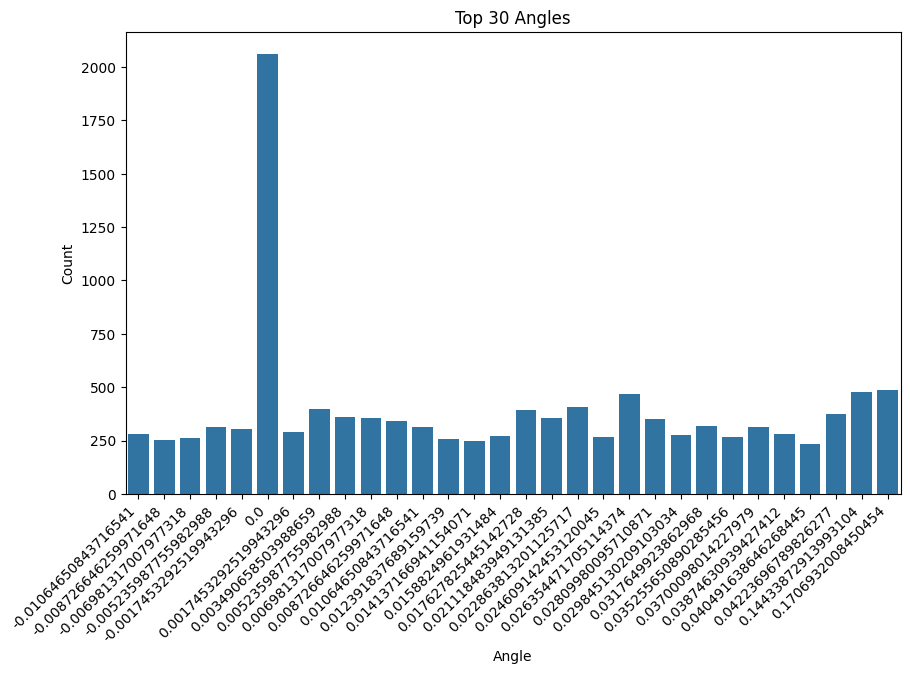

In [ ]:
# Create count plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(dict(counter.most_common(30)).keys()), y=list(dict(counter.most_common(30)).values()))
plt.title('Top 30 Angles')
plt.xlabel('Angle')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

<h2><b>4. Data Cleaning & Preprocessing</b></h2>

In [ ]:
# Define the directory containing your data
data_directory = '/content/drive/MyDrive/SelfDrivingCar/Datasets/Data/driving_dataset/'

In [ ]:
# Create an ImageDataGenerator instance
data_generator = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]

image_size = (240, 240)

In [ ]:
# Load all image filenames
all_filenames = [os.path.join(data_directory, filename) for filename in os.listdir(data_directory) if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg')]

# Create a DataFrame with the filenames
#data = pd.DataFrame(all_filenames, columns=['filename'])

# Define a function to extract the numerical part from a file path
def extract_numerical_part(filepath):
    return int(filepath.split('/')[-1].split('.')[0])

# Sort the filenames based on the numerical part of the file paths
sorted_filenames = sorted(all_filenames, key=extract_numerical_part)

# Create a DataFrame with the sorted filenames
data = pd.DataFrame({'filename': sorted_filenames})

data['angles'] = df['angles']

In [ ]:
len(all_filenames)

45568

In [ ]:
# Checking the angles for their respective images

print("Original 'angles' from DataFrame df:")
print(df['angles'][110])

print("\n'angles' assigned to DataFrame data:")
print(data['angles'][110])

Original 'angles' from DataFrame df:
0.0651007810993885

'angles' assigned to DataFrame data:
0.0651007810993885


In [ ]:
# Splitting Data into 60:20:20 Ratio

train = data[:27000]
val = data[27000:36000]
test = data[36000:45000]

In [ ]:
print(f"The shape of the Train data: {train.shape}")
print(f"The shape of the Validation data: {val.shape}")
print(f"The shape of the Test data: {test.shape}")

The shape of the Train data: (27000, 2)
The shape of the Validation data: (9000, 2)
The shape of the Test data: (9000, 2)


<h3><b>Process the Image data to vector using ImageDataGenerator and Flow From dataframe</b></h3>

In [ ]:
# Flow images from the DataFrame
train_im_ar_generator = data_generator.flow_from_dataframe(
    dataframe=train,
    directory=data_directory,
    x_col='filename',
    y_col='angles',
    target_size=image_size,
    batch_size=30,  # Use the total number of images as batch size
    class_mode='raw',  # Specify class_mode as 'raw' to use numerical target values
    shuffle=False    # Do not shuffle to maintain order
)

val_im_ar_generator = data_generator.flow_from_dataframe(
    dataframe=val,
    directory=data_directory,
    x_col='filename',
    y_col='angles',
    target_size=image_size,
    batch_size=30,  # Use the total number of images as batch size
    class_mode='raw',  # Specify class_mode as 'raw' to use numerical target values
    shuffle=False     # Do not shuffle to maintain order
)

test_im_ar_generator = data_generator.flow_from_dataframe(
    dataframe=test,
    directory=data_directory,
    x_col='filename',
    y_col='angles',
    target_size=image_size,
    batch_size=30,  # Use the total number of images as batch size
    class_mode='raw',  # Specify class_mode as 'raw' to use numerical target values
    shuffle=False    # Do not shuffle to maintain order
)

Found 27000 validated image filenames.
Found 9000 validated image filenames.
Found 9000 validated image filenames.


In [ ]:
# Create Custom Activation Function for Converting the Steoring Angle from Radian to Degree with the range between -180 t 180 degree.

class Custom2ArcTan(layers.Layer):
    def __init__(self):
        super(Custom2ArcTan, self).__init__()

    def call(self, inputs):
        return 2 * tf.atan(inputs)

# Create an instance of the custom layer
custom_2atan_activation = Custom2ArcTan()

In [ ]:
# testing the function

output_value = custom_2atan_activation(1.57)

print(output_value)

tf.Tensor(2.0073104, shape=(), dtype=float32)


In [ ]:
2*tf.atan(1.57)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0073104>

In [ ]:
print(Custom2ArcTan)

<class '__main__.Custom2ArcTan'>


<h2><b>5. Model Preparation (CNN + LSTM)</b></h2>

In [ ]:
# Define input shape for a single image
input_shape = (240, 240, 3)
# Define the number of timesteps (images in a sequence)
timesteps = 30
# Input layer for the sequence of images
cnn_input_layer = Input(shape=(timesteps,) + input_shape)


#Cnn_model
cnn_model = EfficientNetB1(weights='imagenet', include_top=False,pooling="max", input_shape=input_shape)

# Reshape each image in the sequence to fit the EfficientNetB1 input shape
reshaped_input = Reshape((timesteps,) + cnn_model.input_shape[1:])(cnn_input_layer)

# Apply EfficientNetB1 model to each image in the sequence
cnn_output = TimeDistributed(cnn_model)(reshaped_input)

# Add first Bidirectional LSTM layer with 64 units
lstm_out_1 = Bidirectional(LSTM(64, return_sequences=True))(cnn_output)

# Add second Bidirectional LSTM layer with 32 units
lstm_out_2 = Bidirectional(LSTM(32, return_sequences=False))(lstm_out_1)

# Add output layer
lstm_out_3 = Dense(32)(lstm_out_2)

# Add output layer
lstm_out_4 = Dense(1, activation='linear')(lstm_out_3)

# Add output layer with 2*arctan activation
lstm_output = Dense(1, activation=custom_2atan_activation)(lstm_out_4)

# Create the model
cnn_lstm_model = Model(inputs=cnn_input_layer, outputs=lstm_output)

# Compile the model
cnn_lstm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Print the model summary
cnn_lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 240, 240, 3   0         
                             )]                                  
                                                                 
 reshape (Reshape)           (None, 30, 240, 240, 3)   0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1280)          6575239   
 ributed)                                                        
                                                                 
 bidirectional (Bidirection  (None, 30, 128)           688640    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                       

In [ ]:
print(cnn_output.shape)

(None, 30, 1280)


In [ ]:
batch = train_im_ar_generator.next()
images, angles = batch
print("Images shape:", images.shape)
print("Angles shape:", angles.shape)

Images shape: (30, 240, 240, 3)
Angles shape: (30,)


In [ ]:
# Assuming train_im_ar_generator is your data generator
batch = next(train_im_ar_generator)  # Retrieve a batch of data from the generator
images_batch, angles_batch = batch  # Separate images and angles

# Reshape the images batch
train_batch_reshaped = images_batch.reshape((1, 30, 240, 240, 3))
train_angles_batch_reshaped = angles_batch.reshape((1,30))

print("Reshaped images batch shape:", train_batch_reshaped.shape)
print("Reshaped angles batch shape:", train_angles_batch_reshaped.shape)

Reshaped images batch shape: (1, 30, 240, 240, 3)
Reshaped angles batch shape: (1, 30)


In [ ]:
# Assuming train_im_ar_generator is your data generator
batch = next(val_im_ar_generator)  # Retrieve a batch of data from the generator
images_batch, angles_batch = batch  # Separate images and angles

# Reshape the images batch
val_batch_reshaped = images_batch.reshape((1, 30, 240, 240, 3))
val_angles_batch_reshaped = angles_batch.reshape((1,30))

print("Reshaped images batch shape:", val_batch_reshaped.shape)
print("Reshaped angles batch shape:", val_angles_batch_reshaped.shape)

Reshaped images batch shape: (1, 30, 240, 240, 3)
Reshaped angles batch shape: (1, 30)


In [ ]:
# To show internal errors inside the model

tf.config.run_functions_eagerly(True)

<h2><b>6. Model Training & Validating</b></h2>

In [ ]:
epoch = 100
cnn_lstm_model.fit(train_batch_reshaped, train_angles_batch_reshaped,
                             epochs=epoch,
                             validation_data=(val_batch_reshaped, val_angles_batch_reshaped))

Epoch 1/100
1/1 [==============================] - 15s 15s/step - loss: 0.1373 - mae: 0.3701 - val_loss: 3.0801 - val_mae: 1.7545
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 5.4289 - mae: 2.3299 - val_loss: 2.6867 - val_mae: 1.6385
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 3.7028 - mae: 1.9242 - val_loss: 0.5506 - val_mae: 0.7407
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.4077 - mae: 0.6383 - val_loss: 0.3276 - val_mae: 0.5707
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 1.3634 - mae: 1.1675 - val_loss: 0.5725 - val_mae: 0.7554
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.7429 - mae: 0.8618 - val_loss: 0.3900 - val_mae: 0.6230
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.0460 - mae: 0.2137 - val_loss: 0.1222 - val_mae: 0.3468
Epoch 8/100
1/1 [==============================] - 3s 3s/step - loss: 0.1975 - mae: 0.4441 - val_loss:

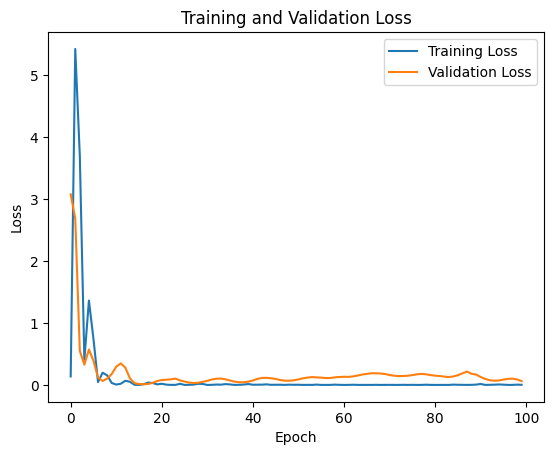

Training Losses: [0.13726165890693665, 5.428914546966553, 3.702791929244995, 0.4077127277851105, 1.3633543252944946, 0.7429317831993103, 0.04595325142145157, 0.19749024510383606, 0.15465526282787323, 0.0318993479013443, 0.0059708175249397755, 0.019333573058247566, 0.06766757369041443, 0.0511135496199131, 0.003024130826815963, 0.0007422319031320512, 0.011392006650567055, 0.03869372978806496, 0.03081955946981907, 0.009633291512727737, 0.018801966682076454, 0.004841044545173645, 0.0009341948898509145, 0.0010597942164167762, 0.018531866371631622, 0.0004012269200757146, 0.002234335755929351, 0.005956884007900953, 0.018615536391735077, 0.015534649603068829, 0.0003006640763487667, 0.0018417882965877652, 0.006224391981959343, 0.004787219222635031, 0.013616603799164295, 0.007968823425471783, 0.0006989426328800619, 0.002226171549409628, 0.006450034212321043, 0.01432259101420641, 0.003474713768810034, 0.003977631218731403, 0.005086610559374094, 0.009347272105515003, 0.0019456525333225727, 0.00307

In [ ]:
# Plot loss graph
plt.plot(cnn_lstm_model.history.history['loss'], label='Training Loss')
plt.plot(cnn_lstm_model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Extract training and validation losses
train_losses = cnn_lstm_model.history.history['loss']
val_losses = cnn_lstm_model.history.history['val_loss']

# Print training and validation losses
print("Training Losses:", train_losses)
print("Validation Losses:", val_losses)

<h2><b>7. Saving the Trained Model</b></h2>

In [ ]:
cnn_lstm_model.save("/content/drive/MyDrive/SelfDrivingCar/cnn_lstm_model_100(2).h5")

<h2><b>8. Conslusion</b></h2>

*   <p>In conclusion, our self-driving car project employing a CNN+LSTM architecture marks a significant stride toward autonomous vehicle development. Through meticulous experimentation and analysis, we've demonstrated the efficacy of our model in accurately predicting steering angles based on input images. Leveraging the complementary strengths of convolutional neural networks and long short-term memory networks, we've effectively captured spatial and temporal dependencies in the driving environment. Our findings underscore the potential of interdisciplinary collaboration and continuous innovation in advancing self-driving technology. Looking forward, further research focusing on robustness, real-time sensor integration, and ethical considerations will be crucial for the widespread adoption of autonomous vehicles, reshaping the future of transportation.</p>

<h2><b>9. References</b></h2>

1.   <b>Github:</b>  https://github.com/PankajKarki/Self-Driving-Car/tree/master
2.   <b>Research paper:</b> End to End Learning for Self-Driving Cars by Nvidia[https://arxiv.org/pdf/1604.07316.pdf]
3.   <b>Nvidia blog:</b> https://devblogs.nvidia.com/deep-learning-self-driving-cars/